In [138]:
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 
%matplotlib inline

In [139]:
data = pd.read_csv('housing.csv')
data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [140]:
# Get some Information about dataset :) 
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [141]:
# This is for Fine : )
data['ocean_proximity'].replace({'<1H OCEAN':'1H OCEAN'},inplace=True)
data['ocean_proximity'].value_counts()

1H OCEAN      9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

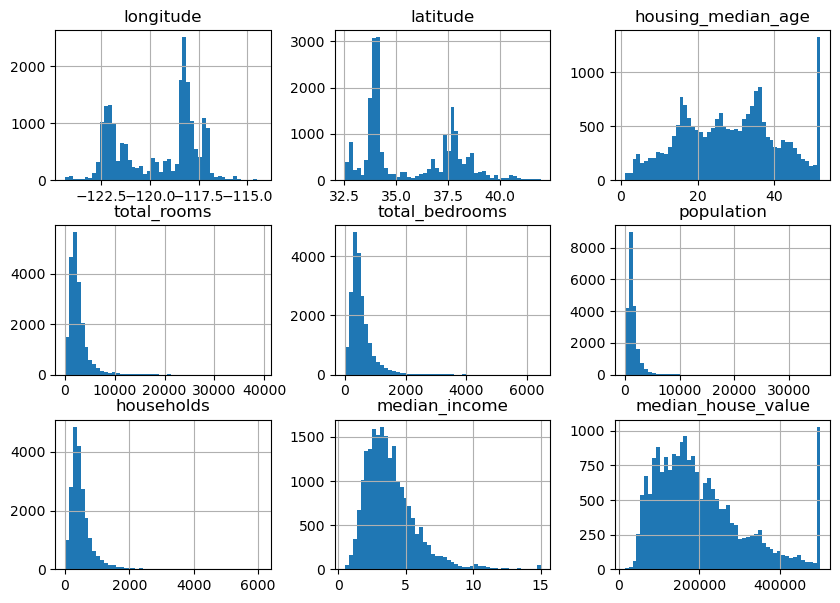

In [142]:
# Get distrbution about features :) 
data.hist(bins=50,figsize=(10,7))
plt.show()

We Get some insights from this distrbution 
'longitude', 'latitude', 'housing_median_age' each of them has multi dist 

In [143]:
# stratify test set "to be insure test set represent whole dataset"
# First Convert feature "income_cat" Numerical into Categorical 
data["income_cat"] = pd.cut(data["median_income"],
bins=[0., 1.5, 3.0, 4.5, 6.,np.inf],
labels=[1, 2, 3, 4, 5])

<AxesSubplot:>

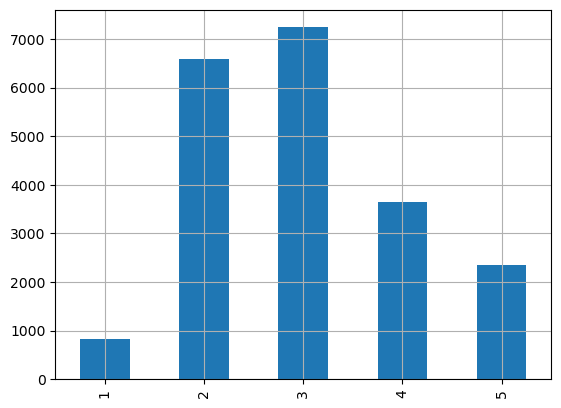

In [144]:
data["income_cat"].value_counts().sort_index().plot.bar(grid= True)

lets work on train set to Get a litle bit insight about dataset 


In [145]:
# split data into strat_train_set , strat_test_set  
from sklearn.model_selection import train_test_split 
strat_train_set , strat_test_set = train_test_split(data,test_size=0.2,stratify=data["income_cat"],random_state=3062002) 

# Check test set "to be insure test set represent training data"
(strat_test_set['income_cat'].value_counts()/len(strat_test_set)).sort_index()

1    0.039971
2    0.318798
3    0.350533
4    0.176357
5    0.114341
Name: income_cat, dtype: float64

In [146]:
# Then Drop "income_cat" from "strat_train_set" & "strat_train_set" 
for set in (strat_train_set , strat_test_set): 
    set.drop('income_cat',axis=1,inplace=True)

Discover and Viz data to Gain some insights 

In [147]:
data_house = strat_train_set.copy()

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

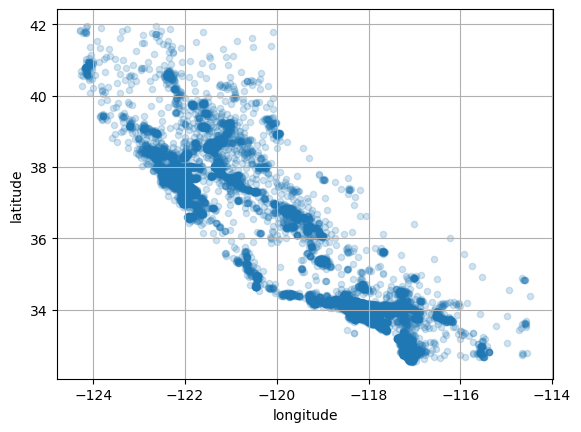

In [148]:
data_house.plot(kind="scatter", x="longitude", y="latitude", grid=True, alpha=0.2)

<Figure size 1500x1000 with 0 Axes>

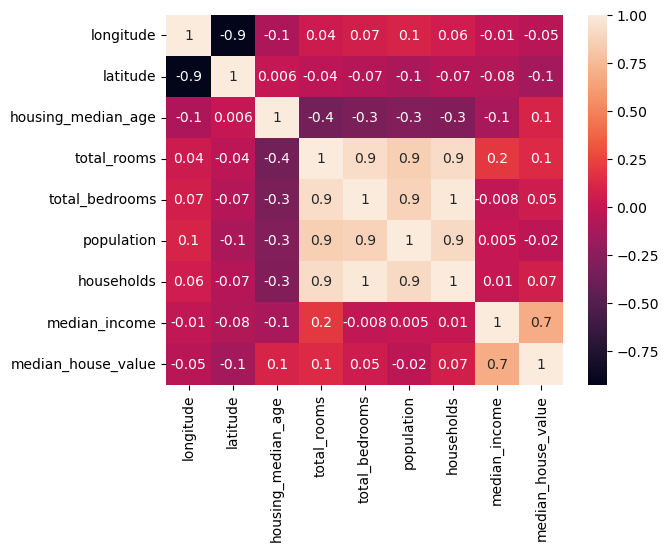

<Figure size 1500x1000 with 0 Axes>

In [149]:
sns.heatmap(data_house.corr(),annot=True,fmt='.1g')
plt.figure(figsize=(15,10))

In [150]:
# do some feature engineering :) 
data_house["rooms_per_house"] = data_house["total_rooms"] / data_house["households"]
data_house["bedrooms_ratio"] = data_house["total_bedrooms"] / data_house["total_rooms"]
data_house["people_per_house"] = data_house["population"] / data_house["households"]

data_house.corr()[['median_income']]

,median_income
longitude,-0.014165
latitude,-0.079628
housing_median_age,-0.123539
total_rooms,0.198274
total_bedrooms,-0.007674
population,0.004557
households,0.013085
median_income,1.000000
median_house_value,0.685223
rooms_per_house,0.321921


#Prepare the Data for Machine Learning Algorithms

In [151]:
housing = strat_train_set.drop('median_house_value',axis=1)
housing_label = strat_train_set['median_house_value'].copy()

In [152]:
# Checking missing value 
strat_train_set.isna().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        169
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [153]:
# Handle Missing values 
median = housing['total_bedrooms'].median()
housing['total_bedrooms'].fillna(median,inplace=True)

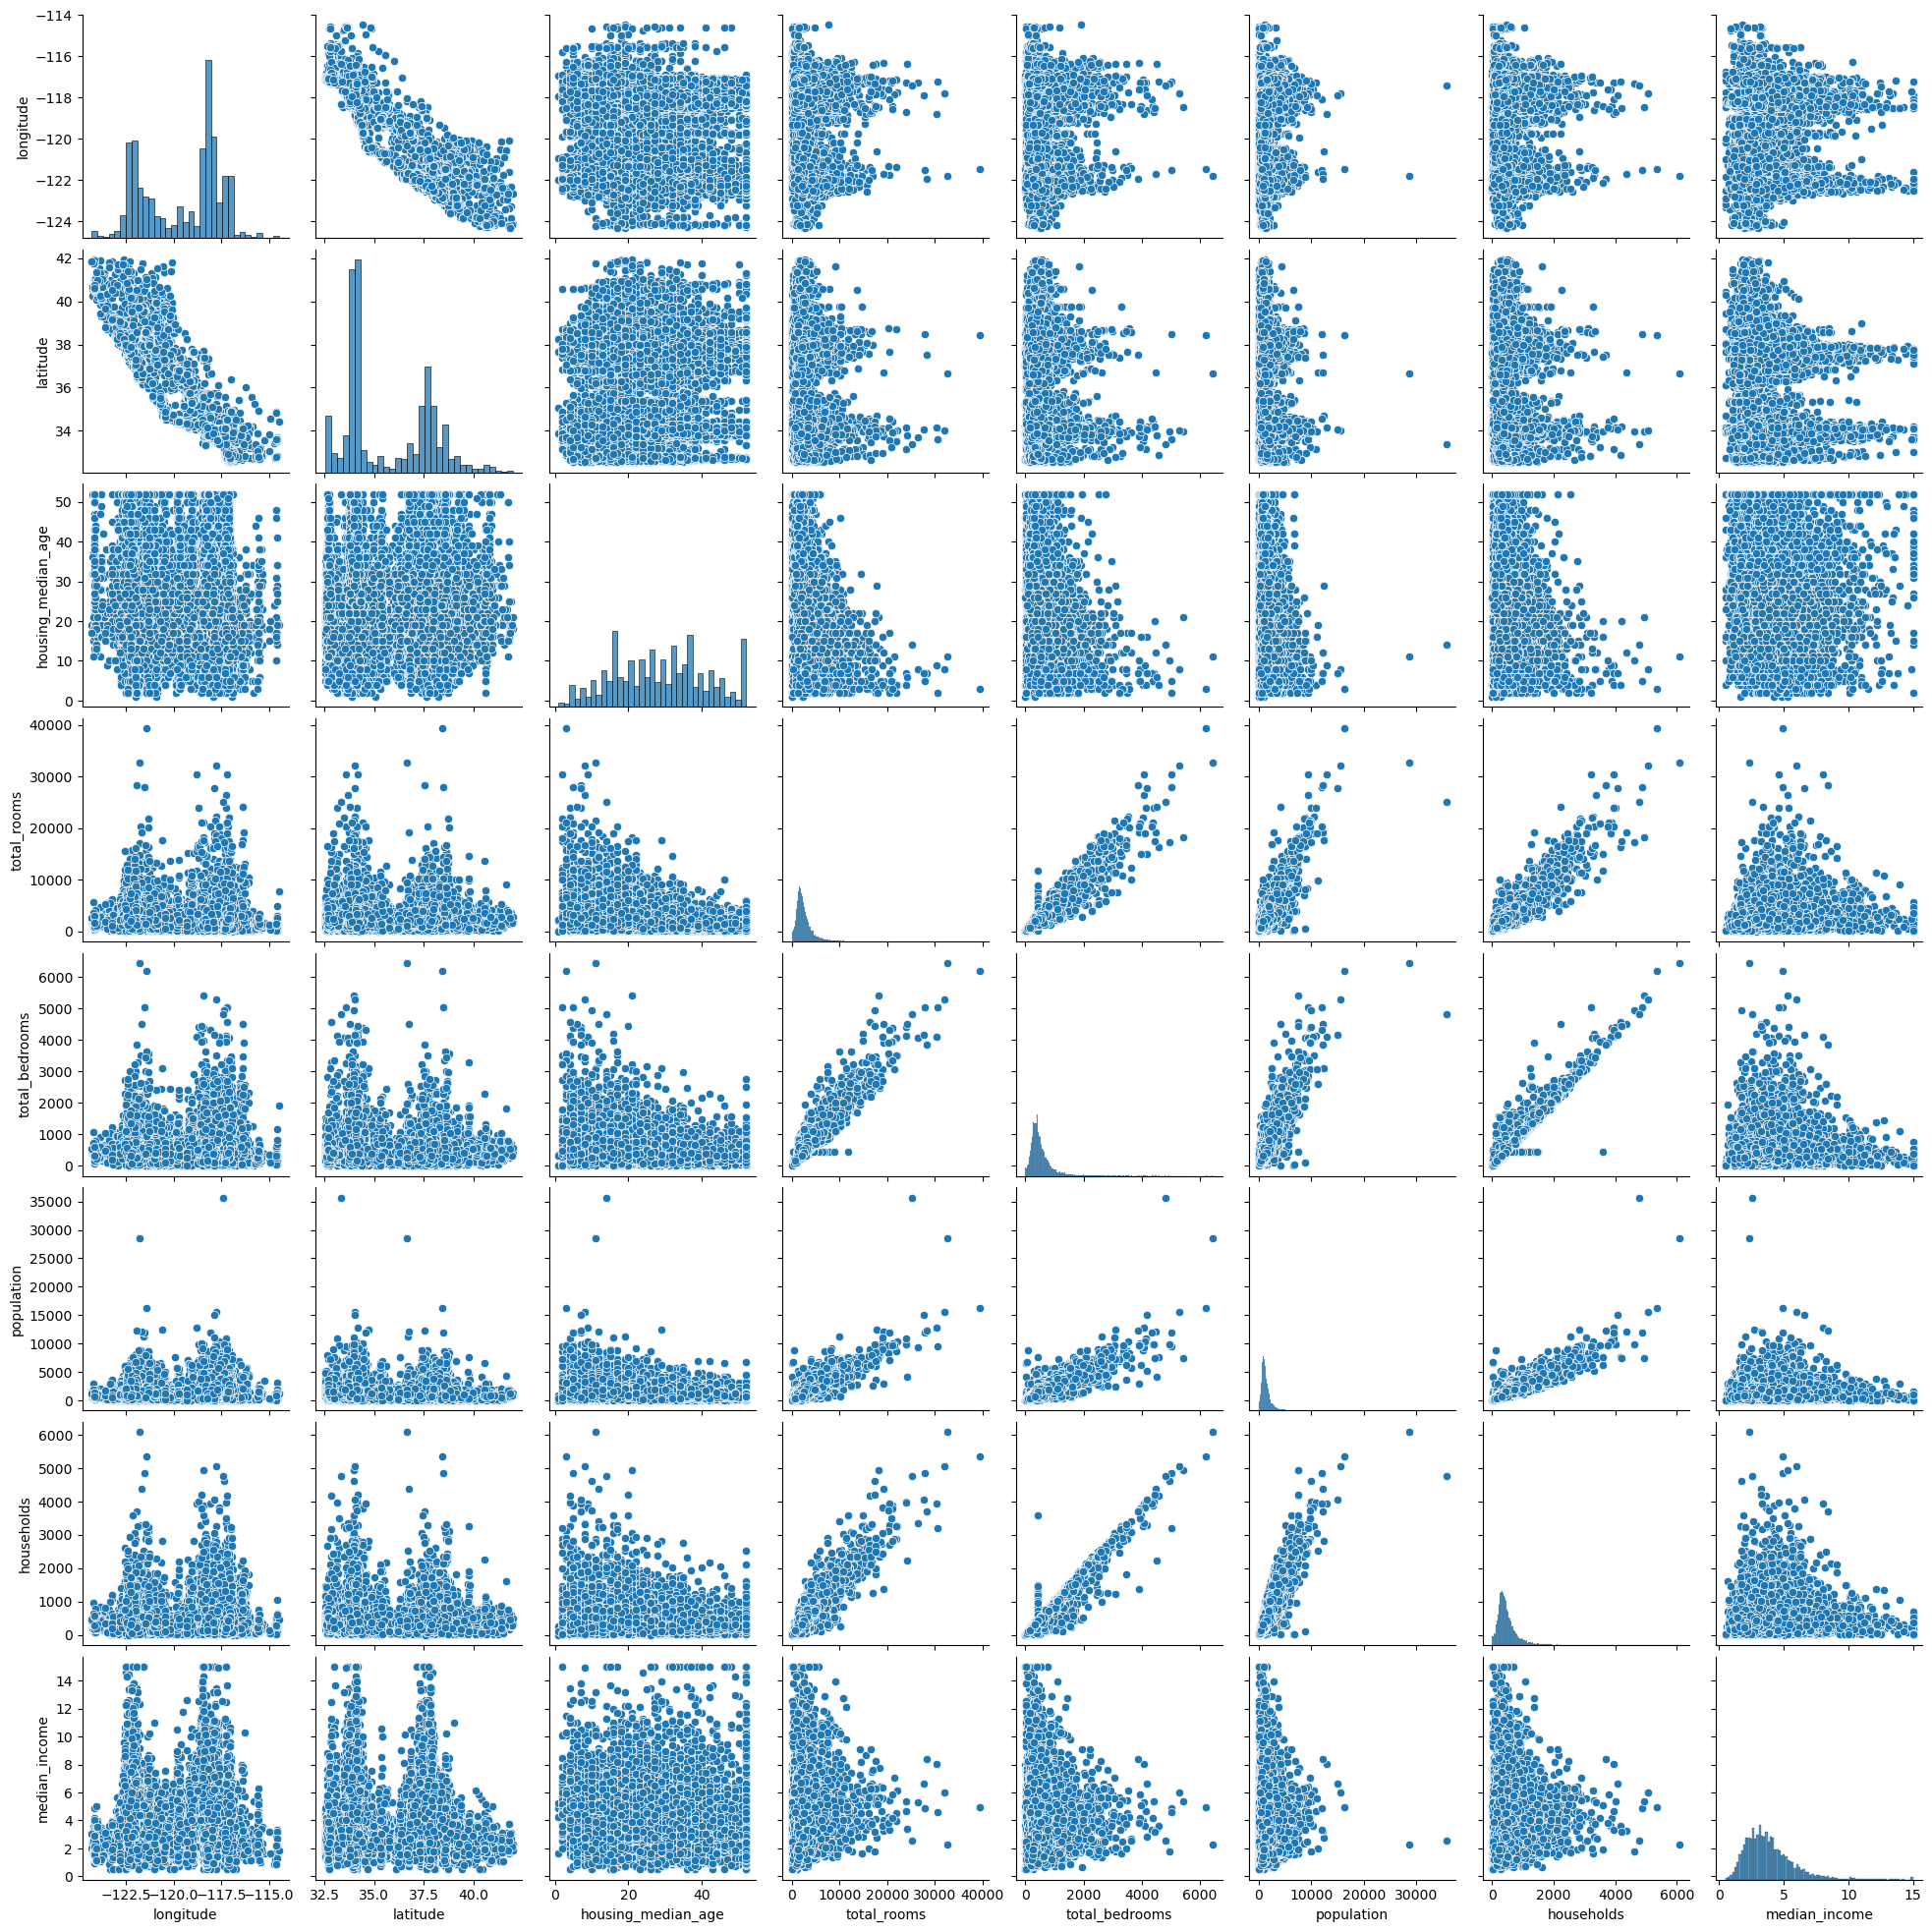

In [154]:
# Get correlation matrix :) 
num_attr = housing.select_dtypes(include=[np.number])
sns.pairplot(num_attr,data=housing)

lets to remove some outlairs :) 

In [155]:
from sklearn.ensemble import IsolationForest 

isolation_forest = IsolationForest(random_state=3062002)
isolation_pred = isolation_forest.fit_predict(num_attr)

# delet outlairs :) 
housing = housing.iloc[isolation_pred == 1]
housing_label = housing_label.iloc[isolation_pred == 1]

Columns Transformation  "Handling categorical attributes && Scaling Numerical attributes" :)  

In [156]:
# Select Categorical Attributes && Numerical Attributes

cat_attrs = list(housing.select_dtypes(include=['object']))
num_attrs = list(housing.select_dtypes(include=[np.number]))

In [161]:
from sklearn.pipeline import make_pipeline, Pipeline 
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer 
from sklearn.preprocessing import StandardScaler 
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import FunctionTransformer

# pipeline for numerical attr :) 
num_pipeline = make_pipeline(SimpleImputer(strategy='median'),StandardScaler())
# pipeline for categorical attr :) 
cat_pipeline = make_pipeline(SimpleImputer(strategy='most_frequent'),OneHotEncoder(handle_unknown='ignore'))


# Pipeline for Housing 
Preprocessing = ColumnTransformer([
    ("num_attrs",num_pipeline,num_attrs), 
    ("cat_attrs",cat_pipeline,cat_attrs),
])


Select and Train a Model

In [162]:
#  Train linear regression model :) 
from sklearn.linear_model import LinearRegression

linear_reg = make_pipeline(Preprocessing,LinearRegression())
linear_reg.fit(housing,housing_label)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num_attrs',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['longitude', 'latitude',
                                                   'housing_median_age',
                                                   'total_rooms',
                                                   'total_bedrooms',
                                                   'population', 'households',
                                                   'median_income']),
                                                 ('cat_attrs',
                                            

In [ ]:
# lets try full pipleline on a few traning instance :)
housing_Predctions = linear_reg.predict(housing)
housing_Predctions[:4]

array([ 89856.57688525, 289259.57149951, 114872.90476304, 122968.28803675])

In [ ]:
from sklearn.metrics import mean_squared_error 

Linear_RME = mean_squared_error(housing_Predctions,housing_label,squared=False)
Linear_RME

65107.53176280053

In [ ]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = make_pipeline(Preprocessing, DecisionTreeRegressor(random_state=42))
tree_reg.fit(housing, housing_label)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num_attrs',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['longitude', 'latitude',
                                                   'housing_median_age',
                                                   'total_rooms',
                                                   'total_bedrooms',
                                                   'population', 'households',
                                                   'median_income']),
                                                 ('cat_attrs',
                                            

In [ ]:
# lets try full pipleline on a few traning instance :) "Decision_Tree_Regressor" 
housing_Predctions = tree_reg.predict(housing)
housing_Predctions[:5]

array([ 76600., 500001.,  98600.,  83600., 246900.])

In [ ]:
tree_RME = mean_squared_error(housing_Predctions,housing_label)
tree_RME
# Oops there is Overfitting !!! 

0.0

Using Cross-Validation Technique To Get Better Evalution :) 

In [ ]:
from sklearn.model_selection import cross_val_score 

linear_model_rmses = -cross_val_score(linear_reg,housing,housing_label,scoring='neg_root_mean_squared_error',cv=10)
pd.Series(linear_model_rmses).describe()

count       10.000000
mean     65162.797290
std       1802.977697
min      62914.686924
25%      64154.000884
50%      64595.673427
75%      66021.374334
max      68502.793996
dtype: float64

In [ ]:
from sklearn.model_selection import cross_val_score 

DTR_model_rmses = -cross_val_score(tree_reg,housing,housing_label,scoring='neg_root_mean_squared_error',cv=10)
pd.Series(DTR_model_rmses).describe()

count       10.000000
mean     67681.995278
std       2696.404194
min      63116.004807
25%      65819.812900
50%      68083.569989
75%      68642.132468
max      71886.985824
dtype: float64

Fine-Tune Model

In [168]:
# using Grid search Technique to get best hyperparameter :) 
from sklearn.model_selection import GridSearchCV
# Full pipeline 
full_pipeline = Pipeline([
    ("preprocessing",Preprocessing), 
    ('RandomRorest',DecisionTreeRegressor(random_state=3062002)),
])
param_grid = [
    {'RandomRorest__max_features': [4, 6, 8, 10]}
]
grid_search = GridSearchCV(full_pipeline, param_grid, cv=3,
                           scoring='neg_root_mean_squared_error')
grid_search.fit(housing, housing_label)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('num_attrs',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('standardscaler',
                                                                                          StandardScaler())]),
                                                                         ['longitude',
                                                                          'latitude',
                                                                          'housing_median_age',
                                                                          'total_rooms',
                             

In [ ]:
final_model = grid_search.best_estimator_

In [ ]:
X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

In [ ]:
final_model.predict(X_test)
final_predictions = final_model.predict(X_test)

final_rmse = mean_squared_error(y_test, final_predictions, squared=False)
print(final_rmse)

74673.85172045277
